In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV

from scipy.sparse import csr_matrix
from scipy.stats import uniform, loguniform, randint

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from google.colab import drive

from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator,TransformerMixin

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pickle

from prettytable import PrettyTable

In [ ]:
pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


- Data contains various categorical, numerical and text features.

- We have to predict whether the project application will get accepted or not.

- https://www.kaggle.com/c/donorschoose-application-screening

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/preprocessed_data_title.csv',nrows=35000)
data.head(3)

,Unnamed: 0,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,project_title
0,0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,educational support english learners home
1,1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,wanted projector hungry learners
2,2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00,soccer equipment awesome middle school students


In [ ]:
data=data.drop(['Unnamed: 0'],axis=1)

In [ ]:
#some project_title have nan values. replacing them with empty string.

not_string=[]
for i in range(len(data)):
  if type(data.project_title.values[i]) != str:
    data['project_title'][i] = ''
    not_string.append(i)
print(len(not_string))

20


In [ ]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=15)

# **Set-1**

<h3>Encoding features:</h3>

- Using column transformer to encode and stack features.
- Making custom transformer for response encoding and sentiment score.

In [ ]:
class ResponseEncoding(BaseEstimator, TransformerMixin):

  def __init__(self):
    super().__init__()

  def fit(self,x,y):
    if isinstance(x, pd.Series):
      x=x.values
    if isinstance(x, np.ndarray):
      if len(x) != len(y):
        print('x and y should be of same length')
      else:
        x_0 = x[np.where(y==0)[0]]
        x_1 = x[np.where(y==1)[0]]
        x_unique, counts = np.unique(x, return_counts=True)
        prob = []
        for i in range(len(x_unique)):
          prob.append(np.array([len(np.where(x_0==x_unique[i])[0]),len(np.where(x_1==x_unique[i])[0])]) / counts[i])
        x_prob = {a:b for a,b in zip(x_unique,prob)}
        self.x_unique_ = x_unique
        self.x_prob_ = x_prob
        return self
    else:
      print('dtype of x should be pandas.series or numpy.ndarray')

  def transform(self,x):
    check_is_fitted(self,msg="fit data before transform")
    x_transform = []
    for i in x:
      try:
        x_transform.append(self.x_prob_[i])
      except KeyError:  #https://stackoverflow.com/questions/6380290/python-if-error-raised-i-want-to-stay-in-script
        x_transform.append(np.array([0.5,0.5]))
    return np.array(x_transform)

  def fit_transform(self,x,y):
    return self.fit(x,y).transform(x)

In [ ]:
r=ResponseEncoding()
r.fit_transform(X_train.school_state.values,y_train)

array([[0.14736842, 0.85263158],
       [0.13578275, 0.86421725],
       [0.15481833, 0.84518167],
       ...,
       [0.1350211 , 0.8649789 ],
       [0.13193305, 0.86806695],
       [0.13193305, 0.86806695]])

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
class SentimentScore( SentimentIntensityAnalyzer , BaseEstimator , TransformerMixin ):

  def __init__(self):
    super().__init__()

  def fit(self,raw_documents,y=None):
    return self

  def transform(self,raw_documents,y=None):
    sentiment_scores = []
    for sentence in raw_documents:
      sentiment_scores.append( list(super().polarity_scores(sentence).values()) )
    return np.array(sentiment_scores)

  def fit_transform(self, raw_documents, y=None):
    return self.fit(raw_documents).transform(raw_documents)

In [ ]:
s = SentimentScore()
s.fit_transform(X_train.essay[:5])

array([[0.    , 0.651 , 0.349 , 0.9936],
       [0.041 , 0.836 , 0.122 , 0.8934],
       [0.015 , 0.714 , 0.271 , 0.984 ],
       [0.012 , 0.639 , 0.349 , 0.9943],
       [0.072 , 0.567 , 0.362 , 0.9959]])

In [ ]:
transform_set1 = make_column_transformer(
    ( TfidfVectorizer(max_df=0.85,stop_words='english') , (6) ), #tfidf on essay
    ( TfidfVectorizer(max_df=0.85,stop_words='english') , (8) ), #tfidf on title
    ( SentimentScore() , (6) ), #sentiment score of essay
    ( ResponseEncoding(), (0) ), #response encoding of categorical features.
    ( ResponseEncoding(), (1) ),
    ( ResponseEncoding(), (2) ),
    ( ResponseEncoding(), (4) ),
    ( ResponseEncoding(), (5) ),
    ( MinMaxScaler() , (3,7) ), #normalizing numerical features 
    )

In [ ]:
a=transform_set1.fit_transform(X_train,y_train)

In [ ]:
transform_set1.output_indices_

{'tfidfvectorizer-1': slice(0, 30412, None),
 'tfidfvectorizer-2': slice(30412, 38428, None),
 'sentimentscore': slice(38428, 38432, None),
 'responseencoding-1': slice(38432, 38434, None),
 'responseencoding-2': slice(38434, 38436, None),
 'responseencoding-3': slice(38436, 38438, None),
 'responseencoding-4': slice(38438, 38440, None),
 'responseencoding-5': slice(38440, 38442, None),
 'minmaxscaler': slice(38442, 38444, None),
 'remainder': slice(0, 0, None)}

<h3>Using BayesSearchCV to choose hyperparameter</h3> 

- Using 35k points to search hyperparameter then trying value of hyperparameter obtained by bayes search on full 100k+ data.

In [ ]:
pipe_set1 = make_pipeline( transform_set1 , xgb.XGBClassifier(random_state=15,eval_metric='auc') )

#https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html
#https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html#

search_space = {
         'xgbclassifier__max_depth ':(1,10),
         'xgbclassifier__n_estimators':(3,50),
         'xgbclassifier__learning_rate':(0.1, .99, 'uniform'),
         'xgbclassifier__subsample':(0.7, 1, 'uniform'),
         'xgbclassifier__colsample_bytree':(0.7, 1, 'uniform'),
         'xgbclassifier__lambda':(1e-4, 1e+3,'log-uniform'),
         'xgbclassifier__scale_pos_weight':(0.15,.99,'uniform')
         }


cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=5) #https://stackoverflow.com/questions/29503689/how-to-run-gridsearchcv-without-cross-validation

opt = BayesSearchCV(pipe_set1, search_space , n_iter=10, cv=cv, verbose=4,return_train_score=True, scoring='roc_auc',refit=True,random_state=22)

opt.fit(X_train, y_train)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1] END xgbclassifier__colsample_bytree=1, xgbclassifier__lambda=48.638024885491454, xgbclassifier__learning_rate=0.6563238423070459, xgbclassifier__max_depth =9, xgbclassifier__n_estimators=7, xgbclassifier__scale_pos_weight=0.8354705593140223, xgbclassifier__subsample=1;, score=(train=0.731, test=0.660) total time=  56.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1] END xgbclassifier__colsample_bytree=1, xgbclassifier__lambda=851.3460657097762, xgbclassifier__learning_rate=0.7205628458255517, xgbclassifier__max_depth =6, xgbclassifier__n_estimators=46, xgbclassifier__scale_pos_weight=0.6607299050010399, xgbclassifier__subsample=1;, score=(train=0.865, test=0.676) total time= 1.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1] END xgbclassifier__colsample_bytree=1, xgbclassifier__lambda=73.70685576039314, xgbclassifier__learning_rate=0.4871592213943209, xgbclassifier__max_dept

BayesSearchCV(cv=ShuffleSplit(n_splits=1, random_state=5, test_size=0.2, train_size=None),
              estimator=Pipeline(steps=[('columntransformer',
                                         ColumnTransformer(transformers=[('tfidfvectorizer-1',
                                                                          TfidfVectorizer(max_df=0.85,
                                                                                          stop_words='english'),
                                                                          6),
                                                                         ('tfidfvectorizer-2',
                                                                          TfidfVectorizer(max_df=0.85,
                                                                                          stop_words='english'),
                                                                          8),
                                                                     

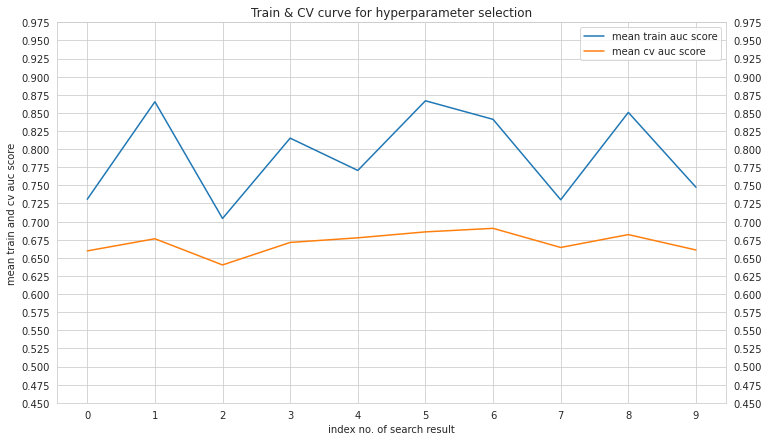

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(np.arange(10), y=opt.cv_results_['mean_train_score'], label='mean train auc score')
sns.lineplot(np.arange(10), y=opt.cv_results_['mean_test_score'], label='mean cv auc score')
plt.xticks(np.arange(10))
plt.yticks(np.arange(0.45,1,0.025))
plt.tick_params(labelright=True)
plt.xlabel('index no. of search result')
plt.ylabel('mean train and cv auc score')
plt.title('Train & CV curve for hyperparameter selection')
plt.legend()
plt.show()

- Index no. 0, 2, 7, 9 are looking good.
- Getting hyperparameter values of search index - 0, 2, 7, 9 in table format.

In [ ]:
result=pd.DataFrame([opt.cv_results_['params'][0],opt.cv_results_['params'][2],opt.cv_results_['params'][7],opt.cv_results_['params'][9]],index=[0,2,7,9])
result.columns=['colsample','lambda','learning_rate','max_depth','n_estimators','scale_pos_weight','subsample']
result['train auc']=opt.cv_results_['mean_train_score'][[0,2,7,9]]
result['test auc']=opt.cv_results_['mean_test_score'][[0,2,7,9]]
result['diff in auc']=opt.cv_results_['mean_train_score'][[0,2,7,9]]-opt.cv_results_['mean_test_score'][[0,2,7,9]]
result

,colsample,lambda,learning_rate,max_depth,n_estimators,scale_pos_weight,subsample,train auc,test auc,diff in auc
0,1,48.638025,0.656324,9,7,0.835471,1,0.730818,0.659583,0.071236
2,1,73.706856,0.487159,7,4,0.230822,1,0.704324,0.640185,0.064139
7,1,2.506149,0.181204,7,14,0.855615,1,0.730138,0.664309,0.065829
9,1,3.671536,0.214425,6,16,0.756006,1,0.747369,0.660829,0.086540


- Selecting index no. 7.

Plotting of heatmap or 3d plot not possible as we have many hyperparameters. Using above graph and table to select best hyperparameter. 

<h3>Training on whole X_train:</h3>

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/preprocessed_data_title.csv')

In [ ]:
df=df.drop(['Unnamed: 0'],axis=1)

In [ ]:
#some project_title have nan values. replacing them with empty string.

not_string=[]
for i in range(len(df)):
  if type(df.project_title.values[i]) != str:
    df['project_title'][i] = ''
    not_string.append(i)
print(len(not_string))

43


In [ ]:
y = df['project_is_approved'].values
X = df.drop(['project_is_approved'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=15)

In [ ]:
len(X_train)

73196

In [ ]:
param = opt.cv_results_['params'][7] #index no. 7 selected as best parameters
       
pipe_set1.set_params(**param)
pipe_set1.fit(X_train,y_train)
y_predict_train = pipe_set1.predict_proba(X_train)[:,1]
y_predict_test = pipe_set1.predict_proba(X_test)[:,1]
auc_score_set1_train = roc_auc_score(y_train, y_predict_train )
auc_score_set1_test = roc_auc_score(y_test, y_predict_test )
print('Train AUC Score:', auc_score_set1_train)
print('Test AUC Score:', auc_score_set1_test )

confusion_matrix_train_set1 = confusion_matrix(y_train,pipe_set1.predict(X_train),normalize='true')
print('Confusion Matrix - Train:\n',confusion_matrix_train_set1)
confusion_matrix_test_set1 = confusion_matrix(y_test,pipe_set1.predict(X_test),normalize='true')
print('Confusion Matrix - Test:\n',confusion_matrix_test_set1 )

Train AUC Score: 0.6848275008793999
Test AUC Score: 0.6710297413727471
Confusion Matrix - Train:
 [[0. 1.]
 [0. 1.]]
Confusion Matrix - Test:
 [[0. 1.]
 [0. 1.]]


- After training on more points there is some improvement in test auc and overfit is reduced as train and test auc are more close.

<h3>Finding optimal probability threshold</h3>

In [ ]:
fpr_trainset, tpr_trainset, thresholds_train = roc_curve(y_train, y_predict_train)
fpr_testset, tpr_testset ,threshold_testset = roc_curve(y_test, y_predict_test)

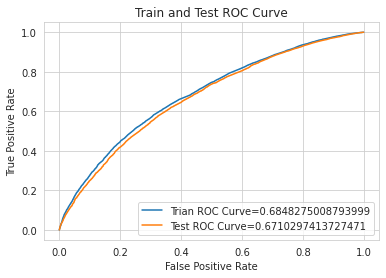

In [ ]:
sns.lineplot(fpr_trainset , tpr_trainset , label=f'Trian ROC Curve={auc_score_set1_train}')
sns.lineplot(fpr_testset , tpr_testset , label=f'Test ROC Curve={auc_score_set1_test}')
plt.title('Train and Test ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
threshold =  thresholds_train[np.argmax(tpr_trainset*(1-fpr_trainset))]
print('Probability Threshold:',threshold)

y_train_after_thresholding = np.copy(y_predict_train)
y_train_after_thresholding = np.where( y_train_after_thresholding >= threshold , 1, 0)
confusion_matrix_train_set1_thresh = confusion_matrix(y_train,y_train_after_thresholding,normalize='true')
print('\nTrain Confusion Matrix after thresholding probability:\n',confusion_matrix_train_set1_thresh)

y_test_after_thresholding = np.copy(y_predict_test)
y_test_after_thresholding = np.where( y_test_after_thresholding >= threshold , 1, 0)
confusion_matrix_test_set1_thresh = confusion_matrix(y_test,y_test_after_thresholding,normalize='true')
print('\nTest Confusion Matrix after thresholding probability:\n',confusion_matrix_test_set1_thresh)

Probability Threshold: 0.8031791

Train Confusion Matrix after thresholding probability:
 [[0.65839574 0.34160426]
 [0.38737462 0.61262538]]

Test Confusion Matrix after thresholding probability:
 [[0.64389082 0.35610918]
 [0.3927369  0.6072631 ]]


<h3>Confusion Matrix</h3>

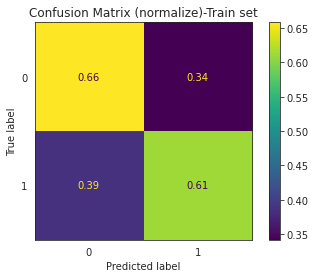

In [ ]:
sns.set_style('white')
ConfusionMatrixDisplay.from_predictions(y_train, y_train_after_thresholding, normalize='true')
plt.title('Confusion Matrix (normalize)-Train set')
plt.show()

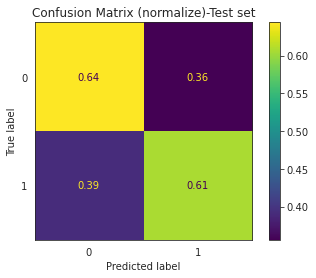

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_after_thresholding, normalize='true') 
plt.title('Confusion Matrix (normalize)-Test set')
plt.show()

# **Set-2**

<h3>Encoding features:</h3>

- Using column transformer to encode and stack features.
- Making custom transformer for w2v-tfidf.

In [ ]:
class TfidfW2vVectorizer(TfidfVectorizer,BaseEstimator,TransformerMixin):

  def __init__(self,**kwargs):  #https://stackoverflow.com/questions/42561085/python-inherit-variables-from-parent-class
    super().__init__(**kwargs)
    
  def fit(self,raw_documents,y=None):
    with open('/content/drive/MyDrive/glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

    self.w2v_vectors_ = []  
    for word in list( super().fit(raw_documents).vocabulary_ ):
      if word in glove_words:
        self.w2v_vectors_.append(model[word])
      else:
        self.w2v_vectors_.append(np.zeros(300))  
    self.w2v_vectors_ = csr_matrix(self.w2v_vectors_)
    return self

  def transform(self,raw_documents):
    check_is_fitted(self,msg="fit raw_documents before transform")
    tfidf_vectors = super().transform(raw_documents)
    tfidf_w2v_vectors = ( np.dot( tfidf_vectors , self.w2v_vectors_ ) ) / ( tfidf_vectors.sum(axis=1) )
    return tfidf_w2v_vectors

  def fit_transform(self, raw_documents, y=None):
    return self.fit(raw_documents).transform(raw_documents)

In [ ]:
t = TfidfW2vVectorizer()
a=t.fit_transform(X_train)
print(a[:5])
print('shape of one document:',a[0].shape)

[[ 0.18165    0.48433    0.52338   ...  0.74978   -0.74108    0.27345  ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.095329  -0.0065557 -0.025445  ... -0.070249   0.47871    0.090787 ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]]
shape of one document: (1, 300)


In [ ]:
transform_set2 = make_column_transformer(
    ( TfidfW2vVectorizer(max_df=0.85,stop_words='english') , (6) ), #tfidf on essay
    ( TfidfW2vVectorizer(max_df=0.85,stop_words='english') , (8) ), #tfidf on title
    ( SentimentScore() , (6) ), #sentiment score of essay
    ( ResponseEncoding(), (0) ), #response encoding of categorical features.
    ( ResponseEncoding(), (1) ),
    ( ResponseEncoding(), (2) ),
    ( ResponseEncoding(), (4) ),
    ( ResponseEncoding(), (5) ),
    ( MinMaxScaler() , (3,7) ), #normalizing numerical features 
    )

In [ ]:
tr=transform_set2.fit_transform(X_train,y_train)
transform_set2.output_indices_

{'tfidfw2vvectorizer-1': slice(0, 300, None),
 'tfidfw2vvectorizer-2': slice(300, 600, None),
 'sentimentscore': slice(600, 604, None),
 'responseencoding-1': slice(604, 606, None),
 'responseencoding-2': slice(606, 608, None),
 'responseencoding-3': slice(608, 610, None),
 'responseencoding-4': slice(610, 612, None),
 'responseencoding-5': slice(612, 614, None),
 'minmaxscaler': slice(614, 616, None),
 'remainder': slice(0, 0, None)}

<h3>Using RandomizedSearchCV</h3> 

- Using 35k points to search hyperparameter then trying value of hyperparameter obtained by randomized search on full 100k+ data.

In [ ]:
pipe_set2 = make_pipeline( transform_set2 , xgb.XGBClassifier(random_state=15,eval_metric='auc') )

param2 = {'xgbclassifier__max_depth ':randint(1, 10),
         'xgbclassifier__n_estimators':randint(3,50),
         'xgbclassifier__learning_rate':uniform,
         'xgbclassifier__subsample':uniform(0.7,.3),
         'xgbclassifier__colsample_bytree':uniform(0.7,.3),
         'xgbclassifier__lambda':loguniform(1e-4, 1e+3),
         'xgbclassifier__scale_pos_weight':uniform,
         }

cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=5)

clf_set2 = RandomizedSearchCV( pipe_set2, param2 , n_iter=10, cv=cv, scoring='roc_auc', return_train_score=True,refit=False, error_score='raise',verbose=4) 

clf_set2.fit(X_train,y_train)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV 1/1] END xgbclassifier__colsample_bytree=0.8627749076735466, xgbclassifier__lambda=0.004936579433302956, xgbclassifier__learning_rate=0.06650725202282548, xgbclassifier__max_depth =7, xgbclassifier__n_estimators=37, xgbclassifier__scale_pos_weight=0.9334528174484704, xgbclassifier__subsample=0.846292371821006;, score=(train=0.711, test=0.620) total time= 1.5min
[CV 1/1] END xgbclassifier__colsample_bytree=0.7479898001172959, xgbclassifier__lambda=0.4778425338367052, xgbclassifier__learning_rate=0.5432838620224841, xgbclassifier__max_depth =9, xgbclassifier__n_estimators=15, xgbclassifier__scale_pos_weight=0.5218160076144954, xgbclassifier__subsample=0.9467262531932881;, score=(train=0.756, test=0.621) total time= 1.2min
[CV 1/1] END xgbclassifier__colsample_bytree=0.9722035635717663, xgbclassifier__lambda=0.18529172642060762, xgbclassifier__learning_rate=0.6676890073813825, xgbclassifier__max_depth =9, xgbclassifier__n_es

RandomizedSearchCV(cv=ShuffleSplit(n_splits=1, random_state=5, test_size=0.2, train_size=None),
                   error_score='raise',
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('tfidfw2vvectorizer-1',
                                                                               TfidfW2vVectorizer(),
                                                                               6),
                                                                              ('tfidfw2vvectorizer-2',
                                                                               TfidfW2vVectorizer(),
                                                                               8),
                                                                              ('sentimentscore',
                                                                               SentimentScore(),
                             

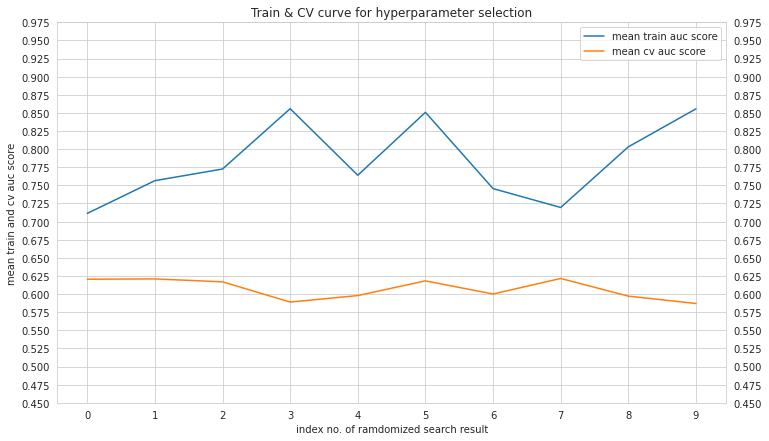

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(np.arange(10), y=clf_set2.cv_results_['mean_train_score'], label='mean train auc score')
sns.lineplot(np.arange(10), y=clf_set2.cv_results_['mean_test_score'], label='mean cv auc score')
plt.xticks(np.arange(10))
plt.yticks(np.arange(0.45,1,0.025))
plt.tick_params(labelright=True)
plt.xlabel('index no. of ramdomized search result')
plt.ylabel('mean train and cv auc score')
plt.title('Train & CV curve for hyperparameter selection')
plt.legend()
plt.show()

- Getting hyperparameter values for index no. 0, 7.

In [ ]:
result2=pd.DataFrame([clf_set2.cv_results_['params'][0],clf_set2.cv_results_['params'][7]],index=[0,7])
result2.columns=['colsample','lambda','learning_rate','max_depth','n_estimators','scale_pos_weight','subsample']
result2['train auc']=clf_set2.cv_results_['mean_train_score'][[0,7]]
result2['test auc']=clf_set2.cv_results_['mean_test_score'][[0,7]]
result2['diff in auc']=clf_set2.cv_results_['mean_train_score'][[0,7]]-clf_set2.cv_results_['mean_test_score'][[0,7]]
result2

,colsample,lambda,learning_rate,max_depth,n_estimators,scale_pos_weight,subsample,train auc,test auc,diff in auc
0,0.862775,0.004937,0.066507,7,37,0.933453,0.846292,0.711320,0.620500,0.090820
7,0.986978,0.000335,0.065907,7,40,0.465487,0.980577,0.719468,0.621559,0.097909


- Selecing index 7.
- When trained on more data points overfit will probably reduce. we do not want any reduction in auc score so using low lambda value result as low lambda will make model less conservative.

<h3>Training on whole X_train:</h3>

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/preprocessed_data_title.csv')

In [ ]:
df=df.drop(['Unnamed: 0'],axis=1)

In [ ]:
not_string=[]
for i in range(len(df)):
  if type(df.project_title.values[i]) != str:
    df['project_title'][i] = ''
    not_string.append(i)
print(len(not_string))

43


In [ ]:
y = df['project_is_approved'].values
X = df.drop(['project_is_approved'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=15)

In [ ]:
len(X_train)

73196

In [ ]:
param = clf_set2.cv_results_['params'][7]

pipe_set2.set_params(**param)
pipe_set2.fit(X_train,y_train)
y_predict_train = pipe_set2.predict_proba(X_train)[:,1]
y_predict_test = pipe_set2.predict_proba(X_test)[:,1]
auc_score_set2_train = roc_auc_score(y_train, y_predict_train )
auc_score_set2_test = roc_auc_score(y_test, y_predict_test )
print('Train AUC Score:', auc_score_set2_train)
print('Test AUC Score:', auc_score_set2_test )

confusion_matrix_train_set2 = confusion_matrix(y_train,pipe_set2.predict(X_train),normalize='true')
print('Confusion Matrix - Train:\n',confusion_matrix_train_set2)
confusion_matrix_test_set2 = confusion_matrix(y_test,pipe_set2.predict(X_test),normalize='true')
print('Confusion Matrix - Test:\n',confusion_matrix_test_set2 )

Train AUC Score: 0.6563155329568258
Test AUC Score: 0.639807968264264
Confusion Matrix - Train:
 [[2.43616349e-03 9.97563837e-01]
 [1.77096582e-04 9.99822903e-01]]
Confusion Matrix - Test:
 [[1.64865360e-03 9.98351346e-01]
 [3.26872160e-04 9.99673128e-01]]


<h3>Finding optimal probability threshold</h3>

In [ ]:
fpr_trainset, tpr_trainset, thresholds_train = roc_curve(y_train, y_predict_train)
fpr_testset, tpr_testset ,threshold_testset = roc_curve(y_test, y_predict_test)

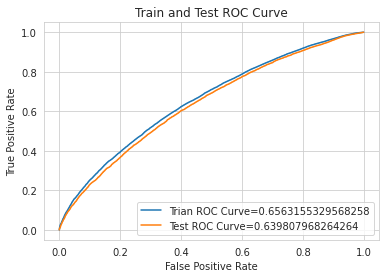

In [ ]:
sns.lineplot(fpr_trainset , tpr_trainset , label=f'Trian ROC Curve={auc_score_set2_train}')
sns.lineplot(fpr_testset , tpr_testset , label=f'Test ROC Curve={auc_score_set2_test}')
plt.title('Train and Test ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
threshold =  thresholds_train[np.argmax(tpr_trainset*(1-fpr_trainset))]
print('Probability Threshold:',threshold)

y_train_after_thresholding = np.copy(y_predict_train)
y_train_after_thresholding = np.where( y_train_after_thresholding >= threshold , 1, 0)
confusion_matrix_train_set2_thresh = confusion_matrix(y_train,y_train_after_thresholding,normalize='true')
print('\nTrain Confusion Matrix after thresholding probability:\n',confusion_matrix_train_set2_thresh)

y_test_after_thresholding = np.copy(y_predict_test)
y_test_after_thresholding = np.where( y_test_after_thresholding >= threshold , 1, 0)
confusion_matrix_test_set2_thresh = confusion_matrix(y_test,y_test_after_thresholding,normalize='true')
print('\nTest Confusion Matrix after thresholding probability:\n',confusion_matrix_test_set2_thresh)

Probability Threshold: 0.6976492

Train Confusion Matrix after thresholding probability:
 [[0.5995669  0.4004331 ]
 [0.37586335 0.62413665]]

Test Confusion Matrix after thresholding probability:
 [[0.5799597  0.4200403 ]
 [0.38057726 0.61942274]]


<h3>Confusion Matrix</h3>

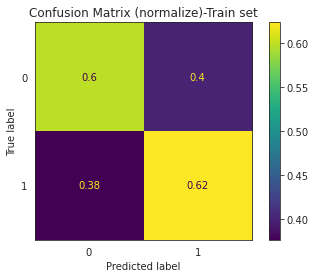

In [ ]:
sns.set_style('white')
ConfusionMatrixDisplay.from_predictions(y_train, y_train_after_thresholding, normalize='true')
plt.title('Confusion Matrix (normalize)-Train set')
plt.show()

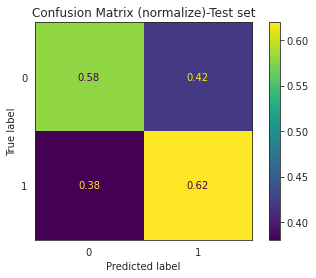

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_after_thresholding, normalize='true') 
plt.title('Confusion Matrix (normalize)-Test set')
plt.show()

Summary-

In [ ]:
columns = ["Set","Search Method", 'lambda','learning_rate','max_depth','n_estimators','scale_pos_weight', "True Positive-Test", "False Positive-Test", "AUC Score-Test"]
myTable = PrettyTable()
myTable.add_column(columns[0], ["Set-1" , "Set-2"])
myTable.add_column(columns[1], ['Bayesian' , 'Randomized'])
myTable.add_column(columns[2], [np.around(opt.cv_results_['params'][7]['xgbclassifier__lambda'],2), np.around(clf_set2.cv_results_['params'][7]['xgbclassifier__lambda'],6)])
myTable.add_column(columns[3], [np.around(opt.cv_results_['params'][7]['xgbclassifier__learning_rate'],2), np.around(clf_set2.cv_results_['params'][7]['xgbclassifier__learning_rate'],3)])
myTable.add_column(columns[4], [opt.cv_results_['params'][7]['xgbclassifier__max_depth '], clf_set2.cv_results_['params'][7]['xgbclassifier__max_depth ']])
myTable.add_column(columns[5], [opt.cv_results_['params'][7][ 'xgbclassifier__n_estimators'], clf_set2.cv_results_['params'][7][ 'xgbclassifier__n_estimators']])
myTable.add_column(columns[6], [np.around(opt.cv_results_['params'][7]['xgbclassifier__scale_pos_weight'],2), np.around(clf_set2.cv_results_['params'][7]['xgbclassifier__scale_pos_weight'],2)])
myTable.add_column(columns[7], [np.around(confusion_matrix_test_set1_thresh[1,1],2) , np.around(confusion_matrix_test_set2_thresh[1,1],2)])
myTable.add_column(columns[8], [np.around(confusion_matrix_test_set1_thresh[0,1],2) , np.around(confusion_matrix_test_set2_thresh[0,1],2)])
myTable.add_column(columns[9], [np.around(auc_score_set1_test,2) , np.around(auc_score_set2_test,2)])
print(myTable)

+-------+---------------+----------+---------------+-----------+--------------+------------------+--------------------+---------------------+----------------+
|  Set  | Search Method |  lambda  | learning_rate | max_depth | n_estimators | scale_pos_weight | True Positive-Test | False Positive-Test | AUC Score-Test |
+-------+---------------+----------+---------------+-----------+--------------+------------------+--------------------+---------------------+----------------+
| Set-1 |    Bayesian   |   2.51   |      0.18     |     7     |      14      |       0.86       |        0.61        |         0.36        |      0.67      |
| Set-2 |   Randomized  | 0.000335 |     0.066     |     7     |      40      |       0.47       |        0.62        |         0.42        |      0.64      |
+-------+---------------+----------+---------------+-----------+--------------+------------------+--------------------+---------------------+----------------+
